In [79]:
import pandas as pd
import numpy as np

In [80]:
df = pd.read_csv('../data/daily-website-visitors.csv')
df.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


In [81]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayMonth'] = df['Date'].dt.day

replace_ch = {',': '.'}
for col in ['Page.Loads', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']:
    df[col] = df[col].str.replace(',', '.')
    df[col] = pd.to_numeric(df[col])

df.head()
# type(df['Date'][0])

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits,Year,Month,DayMonth
0,1,Sunday,1,2014-09-14,2.146,1.582,1.430,152.0,2014,9,14
1,2,Monday,2,2014-09-15,3.621,2.528,2.297,231.0,2014,9,15
2,3,Tuesday,3,2014-09-16,3.698,2.630,2.352,278.0,2014,9,16
3,4,Wednesday,4,2014-09-17,3.667,2.614,2.327,287.0,2014,9,17
4,5,Thursday,5,2014-09-18,3.316,2.366,2.130,236.0,2014,9,18


In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.nn.functional as F


features = ['Day.Of.Week', 'Date', 'Year', 'Month', 'DayMonth', 'Page.Loads', 'First.Time.Visits', 'Returning.Visits']
target = 'Unique.Visits'

# Select features and target variable
data = df[features + [target]]

# Sort by date
data = data.sort_values('Date')
data = data.drop('Date', axis=1)
features.remove('Date')
# Normalize the data
scaler = StandardScaler()
data[['Day.Of.Week', 'Page.Loads', 'First.Time.Visits', 'Returning.Visits']] = scaler.fit_transform(data[['Day.Of.Week', 'Page.Loads', 'First.Time.Visits', 'Returning.Visits']])

# Create sequences for the LSTM
sequence_length = 7
X, y = [], []

for i in range(len(data) - sequence_length):
    X.append(data.iloc[i:i+sequence_length][features].values)
    y.append(data.iloc[i+sequence_length][target])

# X, y = np.array(X), np.array(y)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = F.relu(out[:, -1, :])  # Use the output of the last time step
        out = self.fc(out)
        return out
    # def forward(self, x):
    #     _, (h_n, _) = self.lstm(x)
    #     out = self.fc(h_n[-1])
    #     return out

# Instantiate the model
input_size = len(features)
hidden_size = 64
output_size = 1
num_layers = 2
dropout = 0.2

model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout)

# Define loss function and optimizer
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training the model
num_epochs = 50
losses = []
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        test_loss = criterion(outputs.squeeze(), labels)

print(f'Test Loss: {test_loss.item():.4f}')
# todo: split into validation too

Epoch [1/50], Loss: 31.6869
Epoch [2/50], Loss: 31.1439
Epoch [3/50], Loss: 2.4979
Epoch [4/50], Loss: 2.3410
Epoch [5/50], Loss: 13.5133
Epoch [6/50], Loss: 15.8477
Epoch [7/50], Loss: 44.2025
Epoch [8/50], Loss: 40.7605
Epoch [9/50], Loss: 1.4563
Epoch [10/50], Loss: 1.5014
Epoch [11/50], Loss: 15.3617
Epoch [12/50], Loss: 15.8493
Epoch [13/50], Loss: 12.4118
Epoch [14/50], Loss: 16.0175
Epoch [15/50], Loss: 26.3408
Epoch [16/50], Loss: 14.1017
Epoch [17/50], Loss: 15.9186
Epoch [18/50], Loss: 16.0679
Epoch [19/50], Loss: 28.7919
Epoch [20/50], Loss: 40.8731
Epoch [21/50], Loss: 42.7976
Epoch [22/50], Loss: 15.6482
Epoch [23/50], Loss: 0.9793
Epoch [24/50], Loss: 0.9286
Epoch [25/50], Loss: 1.0509
Epoch [26/50], Loss: 15.6346
Epoch [27/50], Loss: 13.5620
Epoch [28/50], Loss: 0.7972
Epoch [29/50], Loss: 0.9103
Epoch [30/50], Loss: 15.5107
Epoch [31/50], Loss: 42.8695
Epoch [32/50], Loss: 14.7832
Epoch [33/50], Loss: 0.7543
Epoch [34/50], Loss: 15.1957
Epoch [35/50], Loss: 15.6423
Epoc

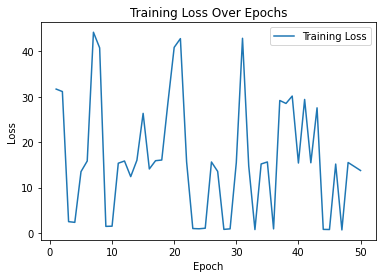

In [98]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(range(1, num_epochs+1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

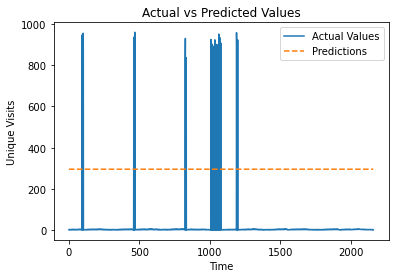

In [99]:
import matplotlib.pyplot as plt

# Switch the model to evaluation mode
model.eval()

# Make predictions on the entire dataset
with torch.no_grad():
    all_inputs = torch.FloatTensor(X)
    all_predictions = model(all_inputs)

# Convert the predictions and actual values to numpy arrays
scaler_y = StandardScaler()
scaler_y.fit(np.array(y).reshape(-1,1))
predictions_np = scaler_y.inverse_transform(all_predictions.squeeze().numpy().reshape(-1, 1)).flatten()
actual_values_np = np.array(y).reshape(-1,1).flatten()

# print(predictions_np.squeeze()[:3], actual_values_np[:3])
# Plot the actual values and predictions
plt.plot(actual_values_np, label='Actual Values', linestyle='-')
plt.plot(predictions_np.squeeze(), label='Predictions', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Unique Visits')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

list